In [99]:
import logging
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from Utils.utils import GetEnvStocks
from datetime import datetime, timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Input
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.dates as mdates


In [10]:
def GetTrainingAndTestSet(stocks):
    print('Getting training and test set')
    stocksAjusted = stocks + '.SA'
    if ' ' in stocks:
        stocksAjusted = ' '.join([stock + '.SA' for stock in stocks])

    last_week_date = datetime.now() - timedelta(weeks=1)
    dataset_train = yf.download(stocksAjusted, start='2000-01-01', end=last_week_date.strftime('%Y-%m-%d'))
    dataset_test = yf.download(stocksAjusted, start=last_week_date.strftime('%Y-%m-%d'), end=datetime.now().strftime('%Y-%m-%d'))
    print('Training and test set retrieved')
    return dataset_train, dataset_test

In [3]:
def CreateXYtrain():
    X_train = []
    y_train = []
    for i in range(60, len(training_set_scaled)):
        X_train.append(training_set_scaled[i - 60:i, 0])
        y_train.append(training_set_scaled[i, 0])
    return np.array(X_train), np.array(y_train)


In [4]:
def CreateRegressor(train_data):
    regressor = Sequential()
    regressor.add(Input(shape=(train_data.shape[1], 1)))

    # Add the LSTM layer and Dropout regularisation
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units=1))
    regressor.compile(optimizer='adam', loss='mean_squared_error')
    return regressor

In [5]:
def SaveModel(regressor, stock):
    regressor.save(f'Models/{stock}.keras')
    print(f'Model for stock {stock} saved')

In [87]:
def CreateTestPredictions(dataset_train, dataset_test):
        dataset_total = pd.concat(
            [pd.DataFrame(dataset_train), pd.DataFrame(dataset_test)], axis=0)
        inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
        inputs = inputs.reshape(-1, 1)
        inputs = sc.transform(inputs)
        X_test = []
        for i in range(60, 60 + len(dataset_test)):
            X_test.append(inputs[i - 60:i, 0])
        print([len(e) for e in X_test])
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        predicted_stock_price = regressor.predict(X_test)
        return sc.inverse_transform(predicted_stock_price)

In [107]:
def CreatePlot(real_stock_price, predicted_stock_price, stock, dates):
    # Convert dates to datetime objects if necessary
    dates = pd.to_datetime(dates)

    plt.figure(figsize=(10, 6))
    plt.plot(dates, real_stock_price, color='red', label=f'{stock} Stock Price')
    plt.plot(dates, predicted_stock_price, color='blue', label=f'{stock} Price Prediction')
    plt.title(f'{stock} Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{stock} Stock Price')
    plt.legend()

    # Format the dates on the x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.gcf().autofmt_xdate()  # Rotate date labels

    plt.savefig(f'../Logs/{stock}.png')
    plt.show()

In [80]:
def EvaluateModel(real_stock_price, predicted_stock_price):
        mae = mean_absolute_error(real_stock_price, predicted_stock_price)

        # Calculando RMSE
        rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))

        # Calculando MAPE
        mape = mean_absolute_percentage_error(real_stock_price, predicted_stock_price)
        print(f'MAE: {mae}')
        print(f'RMSE: {rmse}')
        print(f'MAPE: {mape}')

In [89]:

sc = MinMaxScaler(feature_range=(0, 1))
stock = 'ITUB4'
datasets_train, datasets_test = GetTrainingAndTestSet(stock)

print(f'Training model for stock {stock}')
dataset_train = datasets_train['Close'][f'{stock}.SA'].values.reshape(-1, 1)
dataset_test = datasets_test['Close'][f'{stock}.SA'].values.reshape(-1, 1)
test_dates = datasets_test['Close'][f'{stock}.SA'].keys().to_list()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Getting training and test set
Training and test set retrieved
Training model for stock ITUB4


In [91]:
test_dates

[Timestamp('2024-11-08 00:00:00+0000', tz='UTC'),
 Timestamp('2024-11-11 00:00:00+0000', tz='UTC'),
 Timestamp('2024-11-12 00:00:00+0000', tz='UTC'),
 Timestamp('2024-11-13 00:00:00+0000', tz='UTC'),
 Timestamp('2024-11-14 00:00:00+0000', tz='UTC')]

In [93]:
training_set_scaled = sc.fit_transform(dataset_train)

In [12]:
X_train, y_train = CreateXYtrain()
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
regressor = CreateRegressor(X_train)
regressor.fit(X_train, y_train, epochs=100, batch_size=32)
#SaveModel(regressor, stock)

Epoch 1/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.0280
Epoch 2/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0033
Epoch 3/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0027
Epoch 4/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0024
Epoch 5/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0022
Epoch 6/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0024
Epoch 7/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0019
Epoch 8/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0019
Epoch 9/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0018
Epoch 10/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0017
Epoch 11/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0015
Epoch 12/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0014
Epoch 13/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0014
Epoch 14/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0013
Epoch 15/100
186/186 ━━━━━━━━

FileNotFoundError: [Errno 2] No such file or directory: 'Models/ITUB4.keras'

Model for stock ITUB4 trained and saved
[60, 60, 60, 60, 60]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predictions for stock ITUB4 created


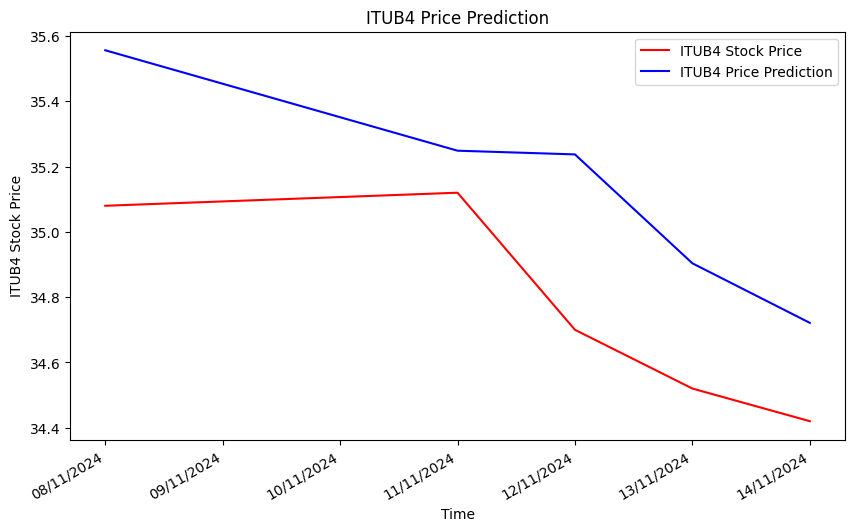

Plot for stock ITUB4 created
MAE: 0.365509033203125
RMSE: 0.3925142219443432
MAPE: 0.010520441935555857
Model for stock ITUB4 evaluated
Training model for stock ITUB4 finished
##################################################
End training model


In [108]:
print(f'Model for stock {stock} trained and saved')
predictPrice = CreateTestPredictions(dataset_train, dataset_test)
print(f'Predictions for stock {stock} created')
CreatePlot(dataset_test,predictPrice ,stock, test_dates)
print(f'Plot for stock {stock} created')
EvaluateModel(dataset_test, predictPrice)
print(f'Model for stock {stock} evaluated')
print(f'Training model for stock {stock} finished')
print('##################################################')
print('End training model')